# 🛍️ SmartCart Starter Notebook
This notebook will guide you through your group project on collaborative filtering and association rule mining for an e-commerce recommender system.

## 📥 Part 1: Data Preprocessing
Steps:
- Load `ecommerce_user_data.csv` and `product_details.csv`
- Merge data if necessary
- Create user-item matrix
- Fill missing ratings with 0
- Group user behavior by category

In [23]:
# Load data
import pandas as pd

user_data = pd.read_csv('ecommerce_user_data.csv')
product_data = pd.read_csv('product_details.csv')

print("User data header:\n\n",user_data.head())
print("\n\nProduct data header:\n\n",product_data.head(),"\n\n")
print("Check for null values for User data:\n\n",user_data.isnull().any(),"\n\n")
print("Check for null values for product data\n\n", product_data.isnull().any())

User data header:

   UserID ProductID  Rating   Timestamp  Category
0   U000     P0009       5  2024-09-08     Books
1   U000     P0020       1  2024-09-02      Home
2   U000     P0012       4  2024-10-18     Books
3   U000     P0013       1  2024-09-18  Clothing
4   U000     P0070       4  2024-09-16      Toys


Product data header:

   ProductID      ProductName     Category
0     P0000      Toys Item 0     Clothing
1     P0001  Clothing Item 1  Electronics
2     P0002     Books Item 2  Electronics
3     P0003  Clothing Item 3  Electronics
4     P0004  Clothing Item 4  Electronics 


Check for null values for User data:

 UserID       False
ProductID    False
Rating       False
Timestamp    False
Category     False
dtype: bool 


Check for null values for product data

 ProductID      False
ProductName    False
Category       False
dtype: bool


In [24]:
# Rename 'Category' in product_data to avoid conflict during merge
product_data = product_data.rename(columns={'Category': 'ProductCategory'})

# Merge datasets
merged_data = pd.merge(user_data, product_data, on='ProductID', how='left')

# Confirm column names after merge
print(merged_data.columns.tolist())
# Output should be: ['UserID', 'ProductID', 'Rating', 'Timestamp', 'Category', 'ProductName', 'ProductCategory']

# Group by user and their original interaction category (from user_data)
user_category_agg = merged_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']

# Preview the result
print(user_category_agg.head())

['UserID', 'ProductID', 'Rating', 'Timestamp', 'Category', 'ProductName', 'ProductCategory']
  UserID     Category  TotalInteractions  AverageRating
0   U000        Books                  6       3.666667
1   U000     Clothing                  3       1.666667
2   U000  Electronics                  3       3.666667
3   U000         Home                  2       1.000000
4   U000         Toys                  6       3.500000


In [25]:
# Create user-item matrix using merged_data for consistency
user_item_matrix = merged_data.pivot_table(index='UserID', columns='ProductID', values='Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)
print(user_item_matrix_filled.head())

ProductID  P0000  P0001  P0002  P0003  P0004  P0005  P0006  P0007  P0008  \
UserID                                                                     
U000         0.0    0.0    0.0    3.0    0.0    5.0    0.0    3.0    0.0   
U001         0.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0   
U002         0.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0   
U003         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U004         0.0    3.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0   

ProductID  P0009  ...  P0090  P0091  P0092  P0093  P0094  P0095  P0096  P0097  \
UserID            ...                                                           
U000         5.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U001         0.0  ...    0.0    5.0    0.0    0.0    0.0    3.0    0.0    0.0   
U002         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U003         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.

In [26]:
# Aggregate user behavior by interaction category (from user_data)
user_category_agg = merged_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']
print(user_category_agg.head())

  UserID     Category  TotalInteractions  AverageRating
0   U000        Books                  6       3.666667
1   U000     Clothing                  3       1.666667
2   U000  Electronics                  3       3.666667
3   U000         Home                  2       1.000000
4   U000         Toys                  6       3.500000


## 🤝 Part 2: User-Based Collaborative Filtering
Steps:
- Use cosine similarity to compare users
- Recommend top-N products based on similar users
- Evaluate with Precision@K and Coverage

### Cosine Similarity

In [27]:
# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_matrix_filled)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)
print(similarity_df.head())

UserID      U000      U001      U002      U003      U004      U005      U006  \
UserID                                                                         
U000    1.000000  0.063071  0.195522  0.023466  0.065412  0.161251  0.160096   
U001    0.063071  1.000000  0.190861  0.000000  0.111332  0.009540  0.000000   
U002    0.195522  0.190861  1.000000  0.065094  0.111662  0.050830  0.027756   
U003    0.023466  0.000000  0.065094  1.000000  0.035737  0.104116  0.026650   
U004    0.065412  0.111332  0.111662  0.035737  1.000000  0.159064  0.057144   

UserID      U007      U008      U009  ...      U040      U041      U042  \
UserID                                ...                                 
U000    0.092083  0.238263  0.274844  ...  0.241693  0.129483  0.156790   
U001    0.172286  0.167460  0.017593  ...  0.121540  0.024075  0.097953   
U002    0.055877  0.000000  0.181229  ...  0.144756  0.000000  0.217465   
U003    0.000000  0.025384  0.288009  ...  0.243836  0.000000  0

### Recommendation function

In [28]:
# Create a recommendation function
# Find the most similar user, recommend products they rated highly that the target user hasn’t rated

def recommend_product(user_id,similarity_df ,user_item_matrix_filled, user_category_agg, n_top = 10):
    # Step 1: get all similar users from similarity_df    
    similar_users = similarity_df[user_id].sort_values(ascending=False).index[1:]
    # print("\nSimilar users to", user_id, "with similarity scores:")
    # print(similarity_df[user_id].sort_values(ascending=False)[1:11]) 
    
    # Step 2: Get the target user's preferred categories sorted by AverageRating
    preferred_categories = user_category_agg[user_category_agg['UserID'] == user_id] \
        .sort_values(by='AverageRating', ascending=False)['Category'].tolist()

    # Step 3: Set up to collect recommended products
    recommended_products = set()
    relevant_items = set(user_item_matrix_filled.loc[user_id][user_item_matrix_filled.loc[user_id] > 0].index)
    
    # Step 4: Loop through similar users and recommend unseen products
    for similar_user in similar_users:
        
        user_interactions = user_item_matrix_filled.loc[similar_user]
        
        # Get products rated by similar user but unseen by target user
        unseen_products = user_interactions[user_interactions > 0].index # this part
        
        for product in unseen_products:
            
            product_category = merged_data[merged_data['ProductID'] == product]['Category'].values[0]
            
            # if the product is in the prefereed category add it
            if product_category in preferred_categories:
                recommended_products.add(product)
                
        #step 5: stop when the length of the set exceeds n_top:
        if len(recommended_products)>=n_top:
            break
                
    return list(recommended_products)[:n_top]

#Sample test
user_id = "U002"
recommended_products = recommend_product(user_id, similarity_df ,user_item_matrix_filled, user_category_agg, 20 )
print(f"Recommended products for {user_id}: {recommended_products}")

Recommended products for U002: ['P0041', 'P0004', 'P0037', 'P0025', 'P0005', 'P0052', 'P0010', 'P0095', 'P0039', 'P0043', 'P0042', 'P0026', 'P0080', 'P0070', 'P0066', 'P0049', 'P0056', 'P0006', 'P0011', 'P0091']


### Evaluation Metrics Formulas:
Precision@K
$$
\text{Precision@K} = \frac{\text{Number of Relevant Items in Top K}}{K}
$$
Recall@K
$$
\text{Recall@K} = \frac{\text{Number of Relevant Items in Top K}}{\text{Total Number of Relevant Items}}
$$
Mean Average Precision (MAP)
$$
\text{MAP} = \frac{1}{N} \sum_{u=1}^{N} \frac{\sum_{k=1}^{K} P(k) \cdot \text{Rel}(k)}{\text{Total Relevant Items}}
$$
Coverage
$$
\text{Coverage} = \frac{\text{Number of Unique Items Recommended}}{\text{Total Number of Available Items}}
$$
Diversity
$$
\text{Diversity} = 1 - \frac{\sum_{u=1}^{N} \sum_{v=1}^{N} S(u, v)}{N \cdot (N-1)}
$$


In [29]:
import numpy as np

# Precision@K: Measures the proportion of recommended items that are relevant.
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_at_k = len(set(recommended_at_k) & set(relevant_items))
    return relevant_at_k / k if k > 0 else 0

# Recall@K: Measures the proportion of relevant items that are recommended.
def recall_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_at_k = len(set(recommended_at_k) & set(relevant_items))
    return relevant_at_k / len(relevant_items) if len(relevant_items) > 0 else 0

# Average Precision: Measures the average proportion of relevant items retrieved at each rank.
def average_precision(recommended_items, relevant_items):
    if not relevant_items:
        return 0
    score = 0.0
    num_hits = 0.0
    for i, item in enumerate(recommended_items):
        if item in relevant_items:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / max(1, len(relevant_items))

# Mean Average Precision (MAP): Computes the mean of average precision across all users.
def mean_average_precision(all_recommendations, all_relevant_items):
    return np.mean([average_precision(recommended, relevant) 
                    for recommended, relevant in zip(all_recommendations, all_relevant_items)])




#sample test:
user_id = "U002"
k = 20
recommended_products = recommend_product(user_id, similarity_df ,user_item_matrix_filled, user_category_agg, 20 )
relevant_items = set(user_item_matrix_filled.loc[user_id][user_item_matrix_filled.loc[user_id] > 0].index)
precision = precision_at_k(recommended_products, relevant_items, k = 20)
recall= recall_at_k(recommended_products, relevant_items, k= 20)
avg_pre = average_precision(recommended_products, relevant_items)

print(f"Precision_at_{k} for {user_id}: {precision}")
print(f"recall_at_{k} for {user_id}: {recall}")
print(f"average_precision_{k} for {user_id}: {avg_pre}")

Precision_at_20 for U002: 0.15
recall_at_20 for U002: 0.21428571428571427
average_precision_20 for U002: 0.051488095238095236


### Recommendation to all users metrics (Precision, Recall, Average_precision)

In [30]:
user_ids = []
precisions = []
recalls = []
avg_pre = []

recommendations = []
relevants = []

for user_id in user_item_matrix_filled.index:
    user_ids.append(user_id)
    recommendation = recommend_product(user_id,similarity_df ,user_item_matrix_filled, user_category_agg, n_top = 20)
    relevant_item = set(user_item_matrix_filled.loc[user_id][user_item_matrix_filled.loc[user_id] > 0].index)

    recommendations.append(recommendation)
    relevants.append(relevant_item)
    
    precisions.append(precision_at_k(recommendation,relevant_item, k = 20 ))
    recalls.append(recall_at_k(recommendation, relevant_item, k = 20))
    avg_pre.append(average_precision(recommendation, relevant_item))

metric_df = pd.DataFrame({
    "UserID": user_ids,
    "Precisions_at_20": precisions,
    "recall_at_20": recalls,
    "Average_precision": avg_pre
})

print(f"Mean average precision of all users: {mean_average_precision(recommendations, relevants)}\n")
metric_df.head(10)

Mean average precision of all users: 0.1589448134368242



,UserID,Precisions_at_20,recall_at_20,Average_precision
0,U000,0.45,0.450000,0.163744
1,U001,0.20,0.307692,0.057042
2,U002,0.15,0.214286,0.051488
3,U003,0.20,0.363636,0.103209
4,U004,0.25,0.294118,0.061964
5,U005,0.30,0.600000,0.238030
6,U006,0.30,0.428571,0.169635
7,U007,0.20,0.363636,0.059543
8,U008,0.35,0.350000,0.215637
9,U009,0.45,0.473684,0.202795


### Coverage metrics

In [31]:
def coverage(all_recommended_products, total_products):
    return len(all_recommended_products)/total_products
total_products = merged_data['ProductID'].nunique() # Number of total products
all_recommended_products = set()
for user_id in user_item_matrix_filled.index:
    recommendation = recommend_product(user_id,similarity_df ,user_item_matrix_filled, user_category_agg, n_top = 20)
    all_recommended_products.update(recommendation)
cvg = coverage(all_recommended_products, total_products)
print(f"Coverage: {cvg * 100:.2f}%")

Coverage: 98.00%


## 🔍 Part 3: Association Rule Mining (Apriori)
Steps:
- Convert user-product interactions to transaction format
- Apply Apriori algorithm to find frequent itemsets
- Generate association rules (support, confidence, lift)

In [32]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Converting the merged data into transactions (list of products purchased by each user)
transactions = merged_data.groupby('UserID')['ProductID'].apply(list).values.tolist()

#Preview
print("Sample transactions:")
for i, transaction in enumerate(transactions[:3]):
    print(f"User {i+1} purchased: {transaction}")

Sample transactions:
User 1 purchased: ['P0009', 'P0020', 'P0012', 'P0013', 'P0070', 'P0014', 'P0048', 'P0079', 'P0042', 'P0050', 'P0046', 'P0021', 'P0028', 'P0047', 'P0005', 'P0003', 'P0007', 'P0071', 'P0044', 'P0033']
User 2 purchased: ['P0051', 'P0055', 'P0095', 'P0033', 'P0002', 'P0054', 'P0050', 'P0020', 'P0091', 'P0086', 'P0030', 'P0044', 'P0037']
User 3 purchased: ['P0083', 'P0081', 'P0020', 'P0005', 'P0049', 'P0071', 'P0054', 'P0086', 'P0014', 'P0067', 'P0059', 'P0052', 'P0085', 'P0072']


In [33]:
#one-hot encoded, apriori algo wants a binary matrix. row --> transaction. columns --> items
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

print("Transaction matrix shape:", transaction_df.shape)
transaction_df.head()

#basically checking if user has the 100 items (T/F)

Transaction matrix shape: (50, 100)


,P0000,P0001,P0002,P0003,P0004,P0005,P0006,P0007,P0008,P0009,...,P0090,P0091,P0092,P0093,P0094,P0095,P0096,P0097,P0098,P0099
0,False,False,False,True,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,True,True


In [12]:
# Find frequent itemsets using Apriori algorithm
# adjust min_support based on your data size (lower for more itemsets)
# only itemsets (combo in a transaction) appearing more than 5% of transatcions will be kept! support --> frequency of itemset appearing in transactions
frequent_itemsets = apriori(transaction_df, min_support=0.05, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x)) 

print("Top frequent itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

#result interpretation:
#in terms of columns, you have the index that you can ignore
#it makes sense that itemsets of length 1 appear the most, since combos are like "more specific", so if we go further down the list, can see the support for itemsets of lenght higher than 2
#also P0070 is the most bought item, with 34% of people buying it
#see bar chart below

Top frequent itemsets:
    support itemsets  length
69     0.34  (P0070)       1
88     0.26  (P0089)       1
50     0.26  (P0051)       1
87     0.24  (P0088)       1
42     0.24  (P0043)       1
29     0.22  (P0030)       1
43     0.22  (P0044)       1
64     0.22  (P0065)       1
4      0.22  (P0004)       1
76     0.22  (P0077)       1


In [34]:
# Association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5) #how often Y appears when X is present

# Filter rules to only show those with lift > 1 (meaningful associations) and sort by confidence andlift
strong_rules = rules[rules['lift'] > 1].sort_values(['confidence', 'lift'], ascending=False)

print("Top association rules:")
print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# so when product (P0006 and p00052 tgt) are bought, user also bought (P0050, P0011). 
# 6% of all transations contain (P0006, P0052) & (P0050, P0011)
# for lift, this combo occurs 16.666667 more often than if (P0006, P0052) and (P0050, P0011) were unrelated
# about confidence, when users buy (P0006, P0052) , they always buy (P0050, P0011)

Top association rules:
        antecedents     consequents  support  confidence       lift
416  (P0006, P0011)  (P0050, P0052)     0.06         1.0  16.666667
418  (P0006, P0052)  (P0011, P0050)     0.06         1.0  16.666667
419  (P0011, P0050)  (P0006, P0052)     0.06         1.0  16.666667
421  (P0050, P0052)  (P0006, P0011)     0.06         1.0  16.666667
438  (P0013, P0088)  (P0064, P0044)     0.06         1.0  16.666667
439  (P0064, P0044)  (P0013, P0088)     0.06         1.0  16.666667
457  (P0013, P0064)  (P0088, P0079)     0.06         1.0  16.666667
460  (P0088, P0079)  (P0013, P0064)     0.06         1.0  16.666667
487  (P0088, P0079)  (P0064, P0044)     0.06         1.0  16.666667
488  (P0064, P0044)  (P0088, P0079)     0.06         1.0  16.666667


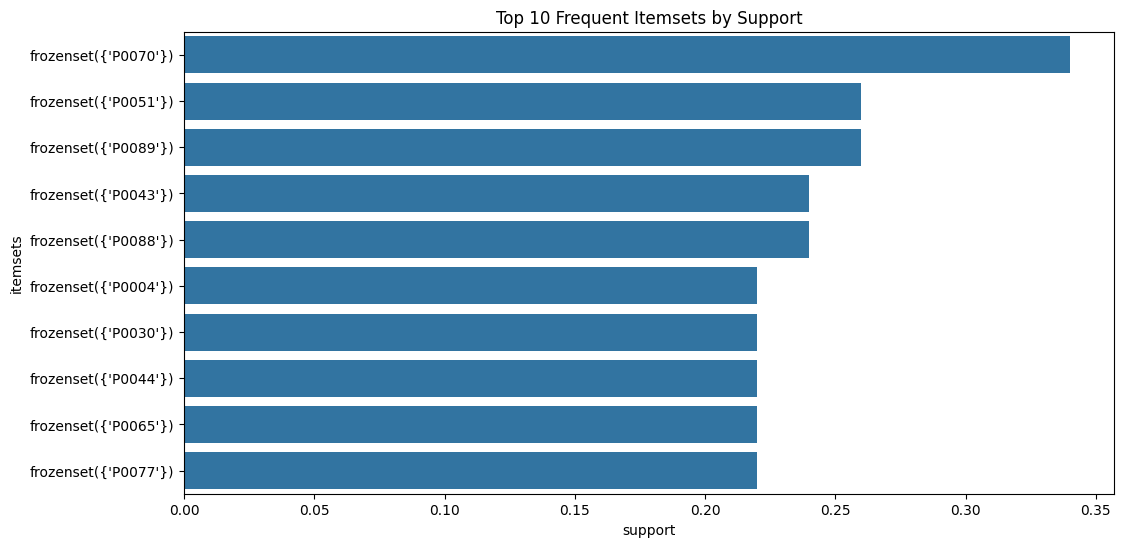

In [45]:
import matplotlib.pyplot as plt 
import seaborn as sns

#Plot frequent itemsets and rules. 
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=frequent_itemsets.nlargest(10, 'support'))
plt.title('Top 10 Frequent Itemsets by Support')
plt.show()

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.scatterplot(data=strong_rules, x='support', y='confidence', size='lift', hue='lift')
# plt.title('Association Rules: Support vs Confidence')
# plt.show()

# #x-axis: How frequently the entire rule (antecedents + consequents) appears in transactions
# #y-axis: when antecedent is bought, consequent is also bought X% of the time.

#bruh let's make a 3D graph instead

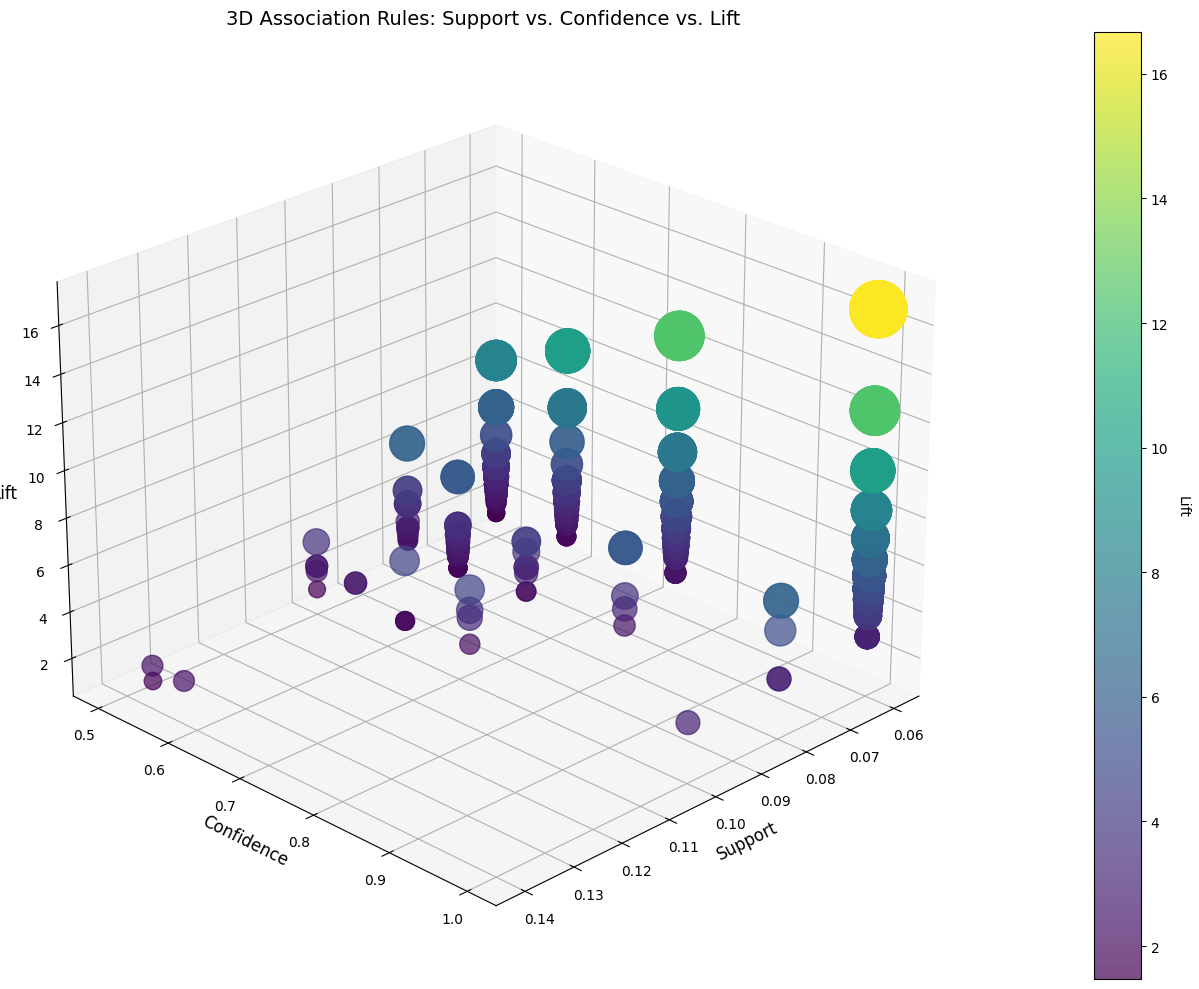

In [46]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    xs=strong_rules['support'],
    ys=strong_rules['confidence'],
    zs=strong_rules['lift'],
    c=strong_rules['lift'],
    cmap='viridis',
    s=100 * strong_rules['lift'],  #Bubble size scales with lift
    alpha=0.7
)

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_zlabel('Lift', fontsize=12)
ax.set_title('3D Association Rules: Support vs. Confidence vs. Lift', fontsize=14)
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('Lift', rotation=270, labelpad=15)
ax.view_init(elev=25, azim=45) 

plt.tight_layout()
plt.show()

In [ ]:
# interpretation of the 3D graph
print("=== Association Rule Details ===")
for i, row in strong_rules.iterrows():
    print(f"\nRule #{i}:")
    print(f"• Antecedents (X): {row['antecedents']}")
    print(f"• Consequents (Y): {row['consequents']}")
    print(f"• Support (P(X∪Y)): {row['support']:.3f}")
    print(f"• Confidence (P(Y|X)): {row['confidence']:.3f}")
    print(f"• Lift: {row['lift']:.3f}")

# Adjust view
ax.view_init(elev=25, azim=45)
plt.tight_layout()
plt.show()

In [ ]:
#Network Graph
G = nx.DiGraph()
for _, row in strong_rules.head(15).iterrows():
    G.add_edge(', '.join(list(row['antecedents'])), ', '.join(list(row['consequents'])), weight=row['confidence']*10)

pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10)
plt.title('Top Association Rules Network')
plt.show()

In [ ]:
#Explore which categories appear most in frequent itemsets.
product_category_map = merged_data[['ProductID', 'Category']].drop_duplicates().set_index('ProductID')['Category']
frequent_itemsets['main_category'] = frequent_itemsets['itemsets'].apply(
    lambda x: max(set([product_category_map[p] for p in x]), key=[product_category_map[p] for p in x].count)
)

plt.figure(figsize=(12, 6))
sns.barplot(x=frequent_itemsets['main_category'].value_counts().values, 
            y=frequent_itemsets['main_category'].value_counts().index)
plt.title('Frequent Itemsets by Category')
plt.show()

## 📊 Part 4: Visualization
Steps:
- Plot user similarity heatmap
- Plot top frequent itemsets
- Visualize top recommendations

In [ ]:
# Heatmap of user similarity
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.title('User Similarity Heatmap')
plt.show()

In [ ]:
# Frequent itemsets bar chart
frequent_itemsets.nlargest(10, 'support').plot(kind='bar', x='itemsets', y='support', legend=False)
plt.title('Top 10 Frequent Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🧠 Part 5: Conceptual Questions
Answer the following questions in your report:
1. How does data sparsity affect performance? Draft answer: it makes recall low
2. What kinds of product bundles were discovered?
3. What improvements would you suggest for real-world deployment?